# Regression with an Abalone Dataset
Run after following notebooks are run:
1. **01_Data_Cleaning**
2. **02_EDA**

## Development Notes/Ideas
- rf
- xgb
- knn
- lasso
- stack
- convert Rings to ordinal categories - this way voting will choose majority vote rather than averaging


## Libraries

In [18]:
## set up libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb

## Load Data

In [2]:
train = pd.read_pickle('train_clean.pkl')
test = pd.read_pickle('test_clean.pkl')

## separate in to features and response variable
x_train = train.drop('Rings', axis=1)
y_train = train['Rings']

x_test = test

## One Hot Encoding / Label Encoding

In [3]:
x_train_onehot = pd.get_dummies(x_train, drop_first=True)
x_test_onehot = pd.get_dummies(x_test, drop_first=True)
print("train dimensions: ", x_train_onehot.shape, "\n","test dimensions: ", x_test_onehot.shape)
x_train_onehot.columns.to_list()

train dimensions:  (90615, 11) 
 test dimensions:  (60411, 11)


['Length',
 'Diameter',
 'Height',
 'Whole weight',
 'Whole weight.1',
 'Whole weight.2',
 'Shell weight',
 'Volume_cube',
 'Density_meat',
 'Sex_I',
 'Sex_M']

In [13]:
## label encode response variable - used for voting algorithms
le = LabelEncoder()
y_train_le = le.fit_transform(y_train)
le.classes_

array([0.69314718, 1.09861229, 1.38629436, 1.60943791, 1.79175947,
       1.94591015, 2.07944154, 2.19722458, 2.30258509, 2.39789527,
       2.48490665, 2.56494936, 2.63905733, 2.7080502 , 2.77258872,
       2.83321334, 2.89037176, 2.94443898, 2.99573227, 3.04452244,
       3.09104245, 3.13549422, 3.17805383, 3.21887582, 3.25809654,
       3.29583687, 3.33220451, 3.40119738])

## Modelling
### Random Forest Averaging

In [4]:
## hyperparameter tuning: n_estimators
param_grid = {'n_estimators' : np.arange(300,450,50), 'n_jobs' : [-1]}
kf = KFold(n_splits=5, shuffle=True, random_state=888)

rf_tuning = GridSearchCV(RandomForestRegressor(random_state=888), param_grid, scoring='neg_mean_squared_log_error', cv=kf, n_jobs=-1)
rf_tuning.fit(x_train_onehot.values, y_train)
None

In [5]:
## find best param with highest accuracy
rf_tuning_accr = rf_tuning.cv_results_['mean_test_score']
print('best_params =', rf_tuning.best_params_)
print('best_score =', rf_tuning.best_score_)
rf_tuning_accr

best_params = {'n_estimators': 400, 'n_jobs': -1}
best_score = -0.002116464972825535


array([-0.00211814, -0.00211721, -0.00211646])

In [6]:
## instantiate rf algorithm, using best tuned param
rf = RandomForestRegressor(n_estimators=400, random_state=888, n_jobs=-1)

## fit model to training data
rf.fit(x_train_onehot.values, y_train); None

#### Feature importance

In [7]:
## List feature importance
rf_ft_imp = pd.DataFrame(data={'Features': x_train_onehot.columns, 'Gini Importance':rf.feature_importances_*100})
rf_ft_imp.sort_values(by='Gini Importance', ascending=False)

,Features,Gini Importance
6,Shell weight,64.176353
8,Density_meat,8.978309
4,Whole weight.1,6.238470
3,Whole weight,4.850089
5,Whole weight.2,4.370962
7,Volume_cube,3.394460
0,Length,2.912683
1,Diameter,2.299838
2,Height,1.521654
9,Sex_I,0.844384


### Random Forest Voting

In [14]:
## instantiate rf algorithm, using best tuned param
rfvot = RandomForestClassifier(n_estimators=400, random_state=888, n_jobs=-1)

## fit model to training data
rfvot.fit(x_train_onehot.values, y_train_le); None

### XGBoost

In [20]:
## convert data to DMatrix
x_train_onehot_D = xgb.DMatrix(data=x_train_onehot, label=y_train)

## cross-validation
params = {'objective':'reg:squaredlogerror', 'max_depth':8, 'eta':0.1}
xgb_tuning = xgb.cv(dtrain=x_train_onehot_D, params=params, num_boost_round=200, early_stopping_rounds=20, nfold=5, as_pandas=True, seed=888)

## mean result
xgb_tuning.tail(1)

,train-rmsle-mean,train-rmsle-std,test-rmsle-mean,test-rmsle-std
199,0.040786,0.000219,0.04496,0.000739


In [23]:
## hyperparameter tuning: n_estimators
param_grid = {'n_estimators' : np.arange(300,600,100), 'max_depth':[8,12], 'eta':[0.1], 'colsample_bytree': [0.5, 0.8], 'reg_alpha':[1],         # parameters to tune
              'objective':['reg:squaredlogerror'], 'n_jobs' : [-1]}                                                                             # fixed parameters
kf = KFold(n_splits=5, shuffle=True, random_state=888)

xgb_tuning = GridSearchCV(xgb.XGBRegressor(random_state=8), param_grid, scoring='neg_mean_squared_log_error', cv=kf)
xgb_tuning.fit(x_train_onehot.values, y_train)
None

In [24]:
## find best param with highest accuracy
xgb_tuning_accr = xgb_tuning.cv_results_['mean_test_score']
print('best_params =', xgb_tuning.best_params_)
print('best_score =', xgb_tuning.best_score_)
xgb_tuning_accr

best_params = {'colsample_bytree': 0.8, 'eta': 0.1, 'max_depth': 12, 'n_estimators': 500, 'n_jobs': -1, 'objective': 'reg:squaredlogerror', 'reg_alpha': 1}
best_score = -0.0020153674473015982


array([-0.00202357, -0.00201979, -0.00201771, -0.00202131, -0.00201814,
       -0.00201655, -0.00202019, -0.00201763, -0.00201638, -0.00201843,
       -0.00201634, -0.00201537])

In [25]:
## instantiate xgb algorithm, using best tuned param
xgbreg = xgb.XGBRegressor(n_estimators= 500, max_depth=12, eta=0.1, colsample_bytree=0.8, reg_alpha=1, objective='reg:squaredlogerror', random_state=8, n_jobs=-1)

## fit model to training data
xgbreg.fit(x_train_onehot.values, y_train); None

## Test Predictions

In [8]:
## set up submission format - i.e. Id & NObeyesdad
id = np.arange(len(train), len(train)+len(test))
submission = pd.DataFrame(data={'id':id, 'Rings':''})

CHECK count of Rings==28 : 0


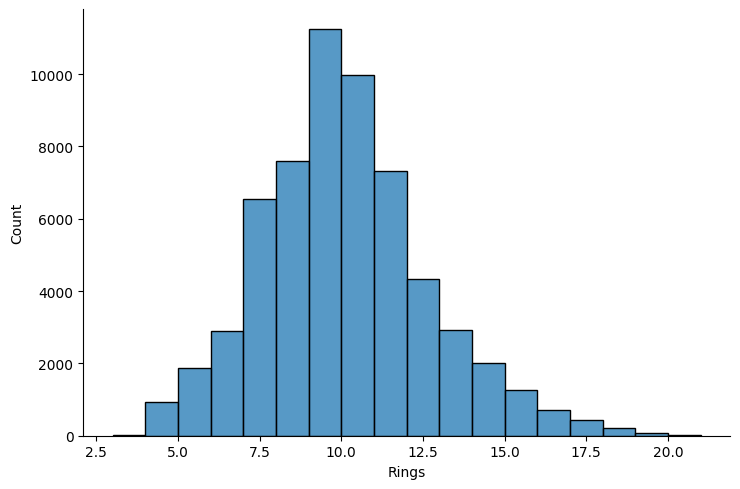

In [16]:
## rf prediction
y_testpred_rf = rf.predict(x_test_onehot.values)
y_testpred_rf = np.exp(y_testpred_rf)-1
y_testpred_rf = np.round(y_testpred_rf)
submission['Rings'] = y_testpred_rf
submission.to_csv('Submissions/test_pred_rf_v2.csv', index=False)

## CHECKS
## check Rings!=28
print('CHECK count of Rings==28 :',sum(submission.Rings==28))

## test prediction histogram of Rings
g=sns.displot(data=submission, x='Rings', binwidth=1, aspect=1.5)

CHECK count of Rings==28 : 0


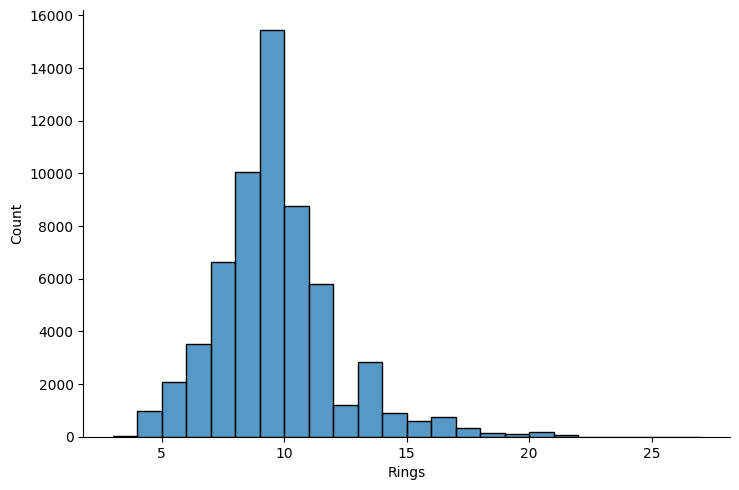

In [17]:
## rfvot prediction
y_testpred_rfvot = rfvot.predict(x_test_onehot.values)
y_testpred_rfvot = le.inverse_transform(y_testpred_rfvot)
y_testpred_rfvot = np.exp(y_testpred_rfvot)-1
y_testpred_rfvot = np.round(y_testpred_rfvot)
submission['Rings'] = y_testpred_rfvot
submission.to_csv('Submissions/test_pred_rfvot_v1.csv', index=False)

## CHECKS
## check Rings!=28
print('CHECK count of Rings==28 :',sum(submission.Rings==28))

## test prediction histogram of Rings
g=sns.displot(data=submission, x='Rings', binwidth=1, aspect=1.5)

CHECK count of Rings==28 : 0


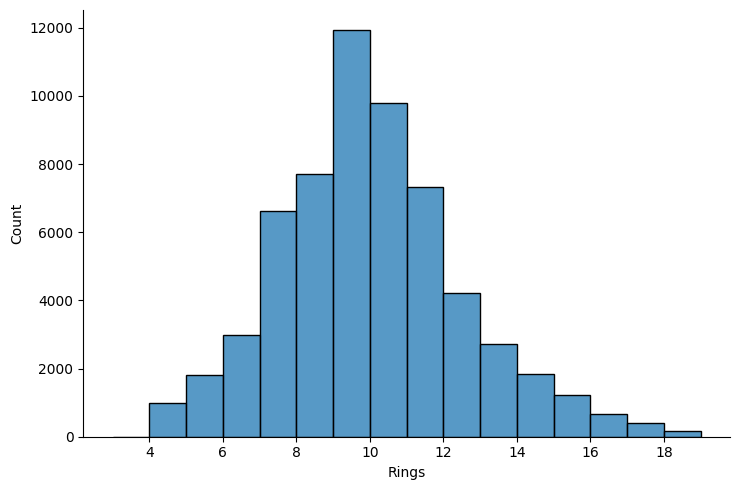

In [26]:
## xgbreg prediction
y_testpred_xgbreg = xgbreg.predict(x_test_onehot.values)
y_testpred_xgbreg = np.exp(y_testpred_xgbreg)-1
y_testpred_xgbreg = np.round(y_testpred_xgbreg)
submission['Rings'] = y_testpred_xgbreg
submission.to_csv('Submissions/test_pred_xgbreg_v1.csv', index=False)

## CHECKS
## check Rings!=28
print('CHECK count of Rings==28 :',sum(submission.Rings==28))

## test prediction histogram of Rings
g=sns.displot(data=submission, x='Rings', binwidth=1, aspect=1.5)